Install missing modules and imports

In [23]:
import sys
import subprocess
import pkg_resources

required = {'scipy', 'numpy', 'pandas', 'openpyxl', 'scikit-learn', 'numba', 'matplotlib','jupyter', 'nbconvert', 'statistics'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
import numba as nb
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from sys import argv
from statistics import mean, stdev
from scipy.stats import t


Transform to PD

In [24]:
file = 'data.xlsx'
df = [pd.read_excel(file, sheet_name = sheet) for sheet in ['CAC', 'DAX', 'IBEX35TR', 'IBEX', 'SX5E', 'SX5T', 'SMI']]
for i in range(len(df)):
    df[i] = df[i].drop(0)

Helpers

In [25]:
@nb.jit(nb.float64(nb.float64, nb.float64), nopython = True)
#A : Payoff, B: VT
def erreur(A, B):
    return abs(min(B - A,0)) - max(B-A,0)
@nb.jit(nb.float64(nb.float64, nb.float64), nopython = True)
def g(x, K):
    return max(x-K, 0)

def Calculate_Kd_Ku(L, ic):
    prices = L['S1/S'].to_numpy()
    Kd, Ku = interval_confiance(prices, ic)
    return Ku, Kd
def Ku_Kd_Train(Data_train, ic):
    Kus = []
    Kds = []
    for i in range(len(Data_train)):
        Ku_, Kd_ = Calculate_Kd_Ku(Data_train[i], ic)
        Kus.append(Ku_)
        Kds.append(Kd_)
    return Kus, Kds 
def interval_confiance(prices, confidence):
    mean_price = mean(prices)
    n = len(prices)
    stdev_price = stdev(prices)
    val = t.ppf((1 + confidence) / 2, n - 1)
    margin_of_error = val * stdev_price / math.sqrt(n)
    lower_bound = mean_price - margin_of_error
    upper_bound = mean_price + margin_of_error
    return (lower_bound, upper_bound)

Split data train test

Méthode I : Variante Min sur Dizaine

In [26]:
CAC_40 = df[0].iloc[:len(df[0])-len(df[0])%10]
#p un pourcentage de Train % Test
#n nombre de jour au total dans le cycle Train + Test
#L de la forme dataframe des données de chaque jour
def create_train_test(L,p,n):
    CAC_40_split = np.array_split(L,len(CAC_40)/(n))
    CAC_40_split = [CAC_40_split[i].iloc[:len(CAC_40_split[i]) - len(CAC_40_split[i])%10] for i in range(len(CAC_40_split))]
    Data_train = []
    Data_test = []
    for i in range(len(CAC_40_split)):
        ind = max(10,int(p*len(CAC_40_split[i]) - p*len(CAC_40_split[i])%10))
        Data_train.append(CAC_40_split[i].iloc[:ind])
        Data_test.append(CAC_40_split[i].iloc[ind:int(len(CAC_40_split[i]))])
    return Data_train, Data_test

Calcul de Ku, Kd

In [27]:
#L de la forme [[s1,s2,s3,...], [s1,s2,s3,...], [s1,s2,s3,...], ...]
def test(L, Ku, Kd, K):
    lamda = [(1 - Kd[i])/(Ku[i] - Kd[i]) for i in range(len(Ku))]
    sum_err = 0
    BS_qs = []
    VTs = []
    PAYOFFs = []
    Errs = []
    STs = []
    max_err = -math.inf
    for i in range(len(L)):
        D = []
        BS_q = []
        for j in range(len(L[i])):
            if j == 0:
                D.append(L[i].iloc[j]['PX_LAST'])
                Teta = 1
            else:
                Teta = (g(Ku[i]*L[i].iloc[j]['PX_LAST'], K)*lamda[i] + g(Kd[i]*L[i].iloc[j]['PX_LAST'], K)*(1-lamda[i]))/((Ku[i]-Kd[i])*L[i].iloc[j]['PX_LAST'])
                D.append(D[-1] + Teta*L[i].iloc[j]['D_S'])
            BS_q.append(Teta)
        VT = D[-1]
        ST = L[i].iloc[len(L[i])-1]['PX_LAST']
        PAYOFF = g(ST, K)
        err = erreur(PAYOFF, VT)/len(L)
        sum_err += err
        max_err = max(max_err,err)
        BS_qs.append(BS_q)
        Errs.append(err)
        VTs.append(VT)
        PAYOFFs.append(PAYOFF)
        STs.append(ST)
    return sum_err, VTs, PAYOFFs, STs, BS_qs, Errs, max_err

In [28]:
#data sous forme dataframe des données journalières
#K strike
#n nombre total de jours dans un cycle Train + Test multiple de 10
#p pourcentage train % test
def train_test(data, K, n, p, ic):
    Data_train, Data_test = create_train_test(data, p, n)
    Kus, Kds = Ku_Kd_Train(Data_train, ic)
    sum_error, VTs, PAYOFFs, STs, BS_qs, Errs, max_err = test(Data_test, Kus, Kds, K)
    return n, p, ic, sum_error, VTs, PAYOFFs, STs, BS_qs, Errs, max_err

In [29]:
val_min = math.inf
MAP = []
for i in range(0,100,10):
    for j in range(900,1000,5):
        sol = train_test(CAC_40, 3500, 210, i/100, j/1000)
        MAP.append([sol[1],sol[2],sol[3]])
        if sol[3] < val_min:
            val_min = sol[3]
            sol_fi = sol



In [30]:
MAPs = [[elem[i] for elem in MAP] for i in range(len(MAP[0]))]
file_df = pd.DataFrame()
file_df['p'] = np.array(MAPs[0])
file_df['ic'] = np.array(MAPs[1])
file_df['sum_error'] = np.array(MAPs[2])
file_df.to_csv('output2.csv', index = False)

red : VT, yellow : PAYOFF, blue : ST, line : K


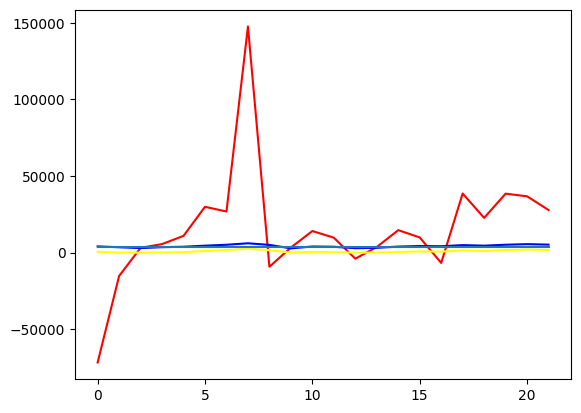

VT - PAYOFF


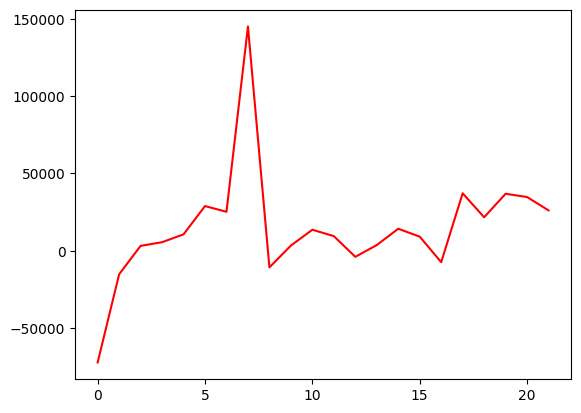

Cumulative Error
max Error
3285.4682464460875
ic :
0.9
p & n
0.6
210


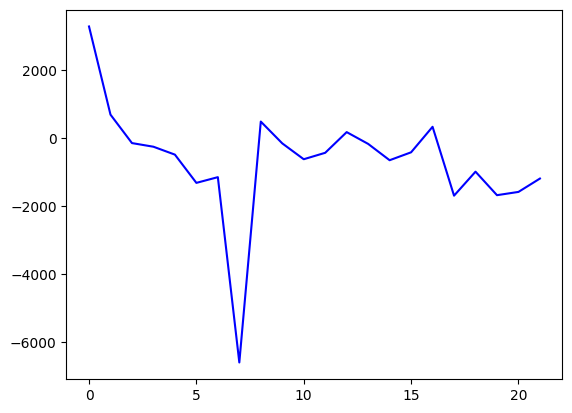

In [31]:
n, p, ic, error, VTs, PAYOFFs, STs, BS_qs, Errs, max_err = sol_fi

print("red : VT, yellow : PAYOFF, blue : ST, line : K")
plt.plot(VTs, color = 'red')
plt.plot(PAYOFFs, color = 'yellow')
plt.plot(STs, color = 'blue')
plt.plot([3500 for i in range(len(STs))])
plt.show()
print("VT - PAYOFF")
plt.plot(np.array(VTs) - np.array(PAYOFFs), color = 'red')
plt.show()
print("Cumulative Error")
plt.plot(Errs, color = 'blue')

print("max Error")
print(max_err)
print("ic :")
print(ic)
print("p & n")
print(p)
print(n)

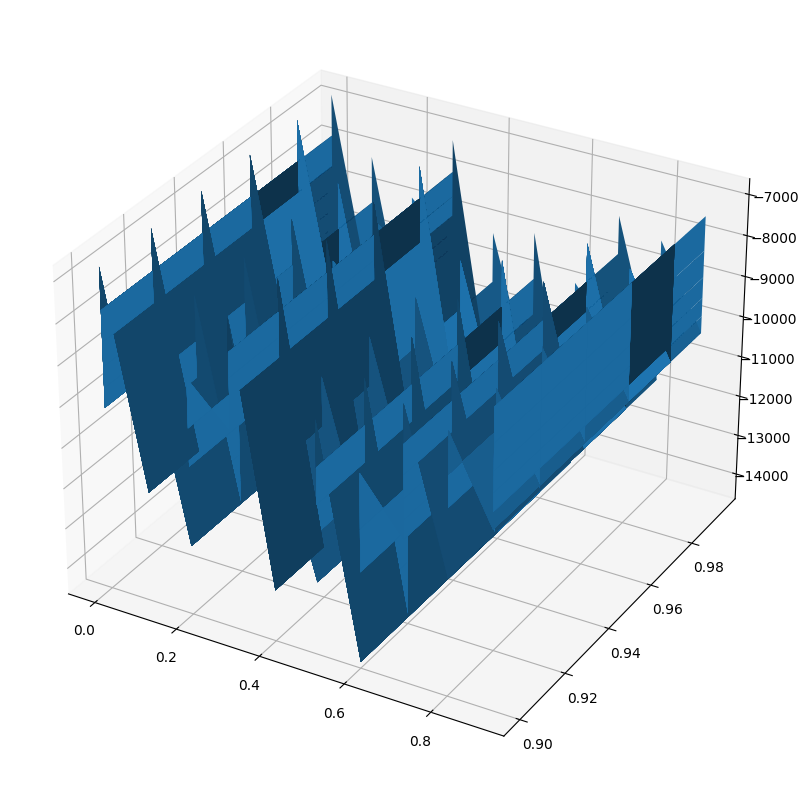

In [32]:

fig = plt.figure(figsize=(10,15))
X, Y = np.meshgrid(MAPs[0],MAPs[1])
Z = np.array([MAPs[2]])
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z)
plt.show()
